# Visualize the Optimization Process

## 采用的模型

| Model                                        | Activation |
| :------------------------------------------- | :--------: |
| deep model：  `Conv(16, (3x3))->Pool(2)->Conv(16, (3x3))->Conv(16, (3x3))->Conv(16, (3x3))->Pool(2)->Conv(10, (1x1))->Pool(7)` |    ReLU    |

> 实验对象：MNIST
>
> 训练采用的方式：`batch_size=400, optimizer=Adam(lr=1e-3), epoch=24, init=xavier_normal`
>
> 完全相同的方式训练8次（因为参数初始化采用`xavier_normal`所以其实每次的初始参数还是略有差异的），每3个epoch记录一次参数，总共训练了24个epoch

In [1]:
import sys
sys.path.insert(0, '..')
import os
import torch
import numpy as np
from argparse import Namespace
from torch import optim
from model import cross_entropy_loss, accuracy
from model import deep_mnist
from dataset import mnist_train_loader, mnist_validate_loader
from solver import HW1Solver
from utils import weight_init
from sklearn.decomposition import PCA

In [2]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
%matplotlib inline

In [3]:
# 设置参数 --- 你可以令visdom=True, 然后在http://localhost:8097上看训练过程
root = os.path.join(os.path.expanduser('~'), 'data')
config = {'batch_size': 400, 'epochs': 24, 'resume': '', 'verbosity': 1, 'dataset': 'mnist', 
          'save_dir': '../pretrained/1_2_1', 'save_freq': 3, 'data_dir': root,
          'use_cuda': True, 'save_grad': False, 'lr': 1e-3, 'valid': True,
          'val_step': 1, 'visdom': False, 'visdom_iter': True, 'visdom_fit': False}
config = Namespace(**config)

In [ ]:
# 训练8次MNIST: 每三轮保存一次 (注：这部分估计得几十分钟)
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
for i in range(1, 9):
    save = os.path.join(config.save_dir, str(i))
    config.save_dir = save
    model = deep_mnist()
    model.apply(weight_init)
    optimizer = optim.Adam(model.parameters(), config.lr)
    loss = cross_entropy_loss
    metrics = [accuracy]
    train_loader = eval(config.dataset + '_train_loader')(root, config.batch_size)
    val_loader = eval(config.dataset + '_validate_loader')(root, config.batch_size)
    solver = HW1Solver(model, optimizer, loss, metrics, train_loader, val_loader, config)
    solver.train()

In [4]:
# PCA处理
step, nums = 3, 8
cmap = get_cmap('hsv')
all_params, one_params, all_accs = [], [], []
for i in range(1, 9):
    checkpoint_base = os.path.join(config.save_dir, str(i))
    checkpoint_filenames = sorted(os.listdir(checkpoint_base))
    for k in range(1, len(checkpoint_filenames)):
        filename = checkpoint_filenames[k]
        checkpoint = torch.load(os.path.join(checkpoint_base, filename))
        model = eval(checkpoint['arch'])()
        model.load_state_dict(checkpoint['state_dict'])
        params = np.zeros((0,))
        for idx, p in enumerate(model.parameters()):
            params = np.append(params, p.cpu().data.numpy().flatten())
            if idx == 2: one_params.append(params)
        all_params.append(params)
        all_accs.append(checkpoint['logger'].entries[k * step]['val_metrics'][0])
all_params = np.array(all_params)
one_params = np.array(one_params)
all_accs = np.array(all_accs)
pca_all = PCA(n_components=2)
pca_one = PCA(n_components=2)
pca_all.fit(all_params)
pca_one.fit(one_params)
xy_all = pca_all.fit_transform(all_params)
xy_one = pca_one.fit_transform(one_params)

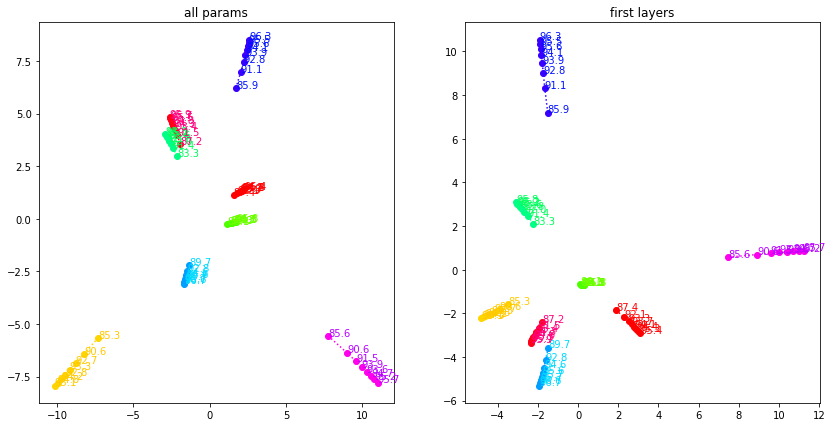

In [5]:
# 可视化结果
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.set_title('all params')
ax2.set_title('first layers')
for i in range(1, 9):
    x_ = xy_all[(i - 1) * nums:i * nums, 0]
    y_ = xy_all[(i - 1) * nums:i * nums, 1]
    x1_ = xy_one[(i - 1) * nums:i * nums, 0]
    y1_ = xy_one[(i - 1) * nums:i * nums, 1]
    a_ = all_accs[(i - 1) * nums:i * nums]
    ax1.plot(x_, y_, 'o:', color=cmap((i - 1) / 7))
    ax2.plot(x1_, y1_, 'o:', color=cmap((i - 1) / 7))
    for xi, yi, x1i, y1i, ai in zip(x_, y_, x1_, y1_, a_):
        ax1.annotate(str('{:.1f}'.format(ai * 100)), xy=(xi, yi),
                     xytext=(xi + 0.004, yi + 0.004), color=cmap((i - 1) / 7.5))
        ax2.annotate(str('{:.1f}'.format(ai * 100)), xy=(x1i, y1i),
                     xytext=(x1i + 0.004, y1i + 0.004), color=cmap((i - 1) / 7.5))
plt.show()

### 结果分析

1. 可以发现不同的初始参数情况下（采用默认的初始化），最后模型收敛到的地方是不一样的，但是精度却是相近的；这就说明了收敛到不同的local minima，只是这些local minima其实都足够好了
2. 说明：如果采用Fully Connected Network，上述图像从中心向两边扩散的现象会更明显（这个实验没放上来，您可以自己试下:)）